In [1]:
from matplotlib import pyplot as plt

import numpy as np
import tensorflow as tf

import os
import pandas as pd

from functools import reduce
from datetime import datetime

from ionmob.models.deep_models import ProjectToInitialSqrtCCS, DeepRecurrentModel
from ionmob.preprocess.data import get_tf_dataset, partition_tf_dataset, split_dataset, to_tf_dataset_kmer
from ionmob.preprocess.helpers import get_sqrt_slopes_and_intercepts, sequence_to_tokens, fit_tokenizer
from ionmob.preprocess.helpers import tokenizer_to_json, tokenizer_from_json
from ionmob.preprocess.tokenization import get_index_dict, get_occurring_kmers, create_count_vectors

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

gpus = tf.config.experimental.list_physical_devices('GPU')

In [2]:
meier = pd.read_parquet('../data/Meier.parquet')
tenzer = pd.read_parquet('../data/Tenzer_unique.parquet')
tenzer_phospho = pd.read_parquet('../data/Tenzer-dda-phospho_unique.parquet')
chang = pd.read_parquet('../data/Chang_unique.parquet')

t = pd.concat([meier, tenzer, tenzer_phospho, chang])

all_pairs = get_occurring_kmers(t)
index_dict = get_index_dict(all_pairs)

In [3]:
meier['tuple-counts'] = create_count_vectors(meier, index_dict)
tenzer['tuple-counts'] = create_count_vectors(tenzer, index_dict)
tenzer_phospho['tuple-counts'] = create_count_vectors(tenzer_phospho, index_dict)
chang['tuple-counts'] = create_count_vectors(chang, index_dict)

In [4]:
phos_train, phos_valid, phos_test = split_dataset(tenzer_phospho)
train = pd.concat([meier, phos_train])
valid = pd.concat([tenzer, phos_valid])
test = pd.concat([chang, phos_test])

In [5]:
slopes, intercepts = get_sqrt_slopes_and_intercepts(t.mz.values, t.charge.values, t.ccs.values)

In [6]:
tf_train = to_tf_dataset_kmer(train.mz, train.charge, train['tuple-counts'].values, train.ccs, batch=False)
tf_valid = to_tf_dataset_kmer(valid.mz, valid.charge, valid['tuple-counts'].values, valid.ccs)
tf_test = to_tf_dataset_kmer(test.mz, test.charge, test['tuple-counts'].values, test.ccs)

tf_train = tf_train.shuffle(train.shape[0]).batch(2048)

In [7]:
from ionmob.models.deep_models import KmerNet

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

early_stopper = tf.keras.callbacks.EarlyStopping(
    monitor='val_output_1_loss',
    patience=5
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='training/rnn/checkpoint',
    monitor='val_output_1_loss',
    save_best_only=True,
    mode='min'
)

csv_logger = tf.keras.callbacks.CSVLogger(
    filename='training/rnn/training.csv',
    separator=',',
    append=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_output_1_loss',
    factor=1e-1,
    patience=3,
    monde='auto',
    min_delta=1e-5,
    cooldown=0,
    min_lr=1e-7
)

cbs = [early_stopper, reduce_lr] # checkpoint, csv_logger, tensorboard_callback

model = KmerNet(
    slopes,
    intercepts
)

model.build([(None, 1), (None, 4), (None, len(index_dict))])

model.compile(loss=tf.keras.losses.MeanAbsoluteError(), loss_weights=[1.],
              optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['mae', 'mean_absolute_percentage_error'])

In [8]:
history = model.fit(tf_train, validation_data=tf_valid, 
                    epochs=100, verbose=False, callbacks=cbs)

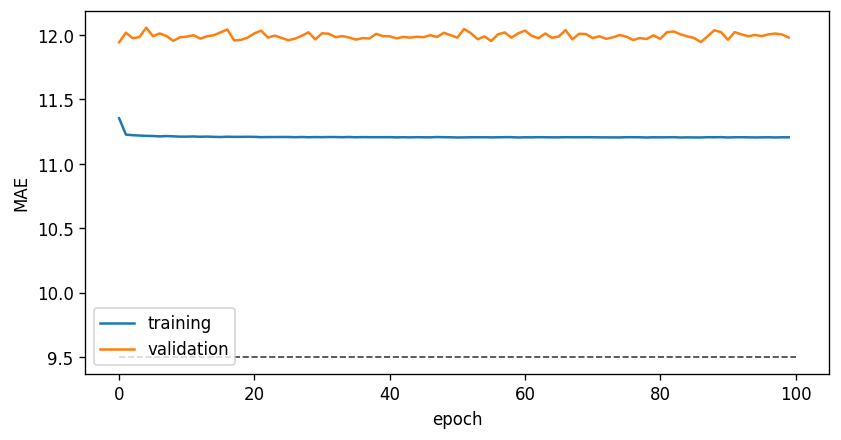

In [14]:
# plot training and validation loss 
plt.figure(figsize=(8, 4), dpi=120)
plt.plot(history.history['mae'], label='training')
plt.plot(history.history['val_mae'], label='validation')
plt.hlines(9.5, xmin=0, xmax=len(history.history['mae']), linestyles='dashed', color='black', linewidth=1, alpha=.75)
plt.xlabel('epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [20]:
model.evaluate(tf_train)

378/378 [==============================] - 8s 15ms/step - loss: 11.2107 - mae: 11.1886 - mean_absolute_percentage_error: 2.1566


[11.210721015930176, 11.188612937927246, 2.1565656661987305]

In [15]:
ccs = model.predict(tf_valid)
valid['ccs_predicted'] = ccs

20/20 [==============================] - 0s 11ms/step


In [22]:
model.save('../pretrained-models/DeepTwoMerModel/', save_format='tf')

INFO:tensorflow:Assets written to: ../pretrained-models/DeepTwoMerModel/assets


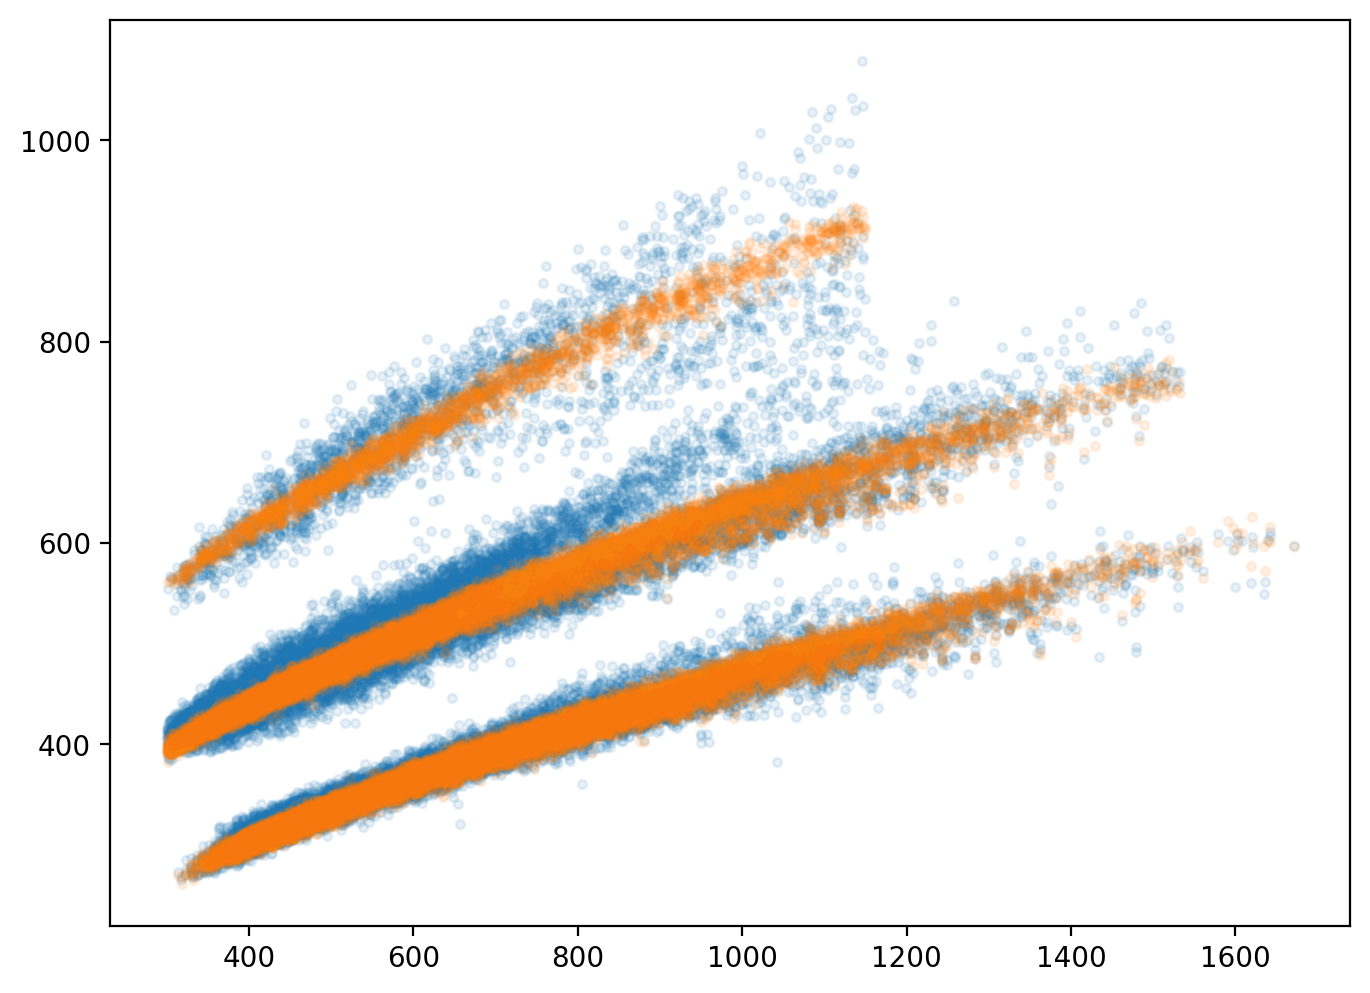

In [16]:
plt.figure(figsize=(8, 6), dpi=200)
plt.scatter(valid.mz, valid.ccs, alpha=.1, s=10)
plt.scatter(valid.mz, valid.ccs_predicted, alpha=.1, s=10)
plt.show()

In [12]:
history.history

{'loss': [11.447125434875488,
  11.312643051147461,
  11.301538467407227,
  11.293009757995605,
  11.285330772399902,
  11.279664039611816,
  11.27254581451416,
  11.272050857543945,
  11.26694393157959,
  11.261468887329102,
  11.259145736694336,
  11.258346557617188,
  11.253540992736816,
  11.253262519836426,
  11.249052047729492,
  11.24659252166748,
  11.247282981872559,
  11.244747161865234,
  11.243672370910645,
  11.243770599365234,
  11.242462158203125,
  11.23952579498291,
  11.239466667175293,
  11.238798141479492,
  11.240070343017578,
  11.23984432220459,
  11.236479759216309,
  11.238280296325684,
  11.235464096069336,
  11.235638618469238,
  11.235417366027832,
  11.236221313476562,
  11.23524284362793,
  11.234671592712402,
  11.235107421875,
  11.233498573303223,
  11.234427452087402,
  11.233267784118652,
  11.233311653137207,
  11.23326587677002,
  11.233262062072754,
  11.23167896270752,
  11.234321594238281,
  11.231403350830078,
  11.23177719116211,
  11.232657432